# Task 9: Random Forests

_All credit for the code examples of this notebook goes to the book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by A. Geron. Modifications were made and text was added by K. Zoch ans S. Korn in preparation for the hands-on sessions_

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Function to save a figure. This also decides that all output files 
# should stored in the subdirectory 'forests'.
PROJECT_ROOT_DIR = "."
EXERCISE = "forests"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "output", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Voting classifiers
Let us first repeat the concept of a voting classifier. You encountered this concept in the lecture so we will only briefly touch it here.

We will use the example from the lecture using a biased coin toss. Feel free to play with the values a little bit yourself!

In [2]:
# Let's define a biased coin toss
heads_proba = 0.51
# All right! Now we toss the coin a few times
n_coin_tosses = 10000
coin_tosses = (np.random.rand(n_coin_tosses, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, n_coin_tosses+1).reshape(-1, 1)


We can now look at the magic of the law of large numbers by plotting the Heads ratio against the number of coin tosses. Let's use a logarithmic axis to see the point of convergence a little better.

Saving figure law_of_large_numbers_plot


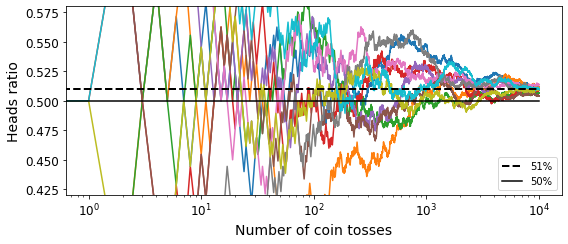

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, n_coin_tosses], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, n_coin_tosses], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.ylim(0.42, 0.58)
plt.xscale("log")
save_fig("law_of_large_numbers_plot")
plt.show()

This is the result you have already seen in the lecture (with a linear x-axis). As you can see, the result converges after a couple of thousand coin tosses. This is the law of large numbers.

# Bagging decision trees

First, let's create some half-moon data (as done in one of the earlier tasks).

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

This code example shows how "bagging" multiple decision trees can improve the classification performance, compared to a single decision tree. Notice how bias and variance change when combining 500 trees as in the example below (it can be seen very nicely in the plot). Please try the following:

1. How does the number of samples affect the performance of the ensemble classifier? Try changing it to the training size (m = 500), or go even higher.
2. How is the performance different when pasting is used instead of bagging (_no_ replacement of instances)?
3. How relevant is the number of trees in the ensemble?

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an instance of a bagging classifier, composed of
# 500 decision tree classifiers. bootstrap=True activates
# replacement when picking the random instances, i.e.
# turning it off will switch from bagging to pasting.
# Here we use all cores by stating n_nobs=-1
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# Create an instance of a single decision tree to compare with.
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

Let's check out the accuracy of our two classifiers:

In [6]:
from sklearn.metrics import accuracy_score

print("Bagging classifier: %.3f"%accuracy_score(y_test, y_pred))
print("Decision tree classifier: %.3f"%accuracy_score(y_test, y_pred_tree))

Bagging classifier: 0.904
Decision tree classifier: 0.856


The bagging classifier outperforms the "normal" decision tree. Let's plot the two:

Saving figure decision_tree_without_and_with_bagging_plot


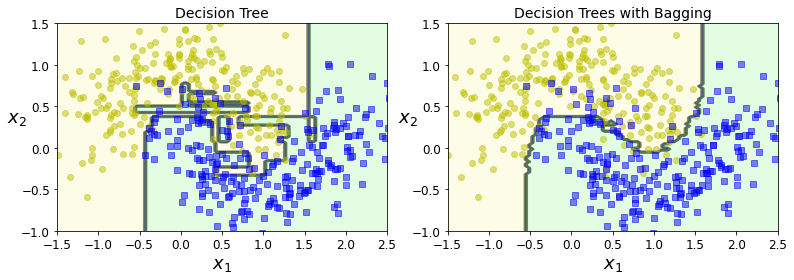

In [7]:
# Now do the plotting of the two.
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

When a bagging classifier is used, evaluation of the performance can be performed _out-of-bag_. Remember what bagging does, and how many instances (on average) are picked from all training instances if the bag is chosen to be the same size as the number of training instances. The fraction of chosen instances should converge against something like

$$1 - \exp(-1) \approx 63.212\%$$

But that also means, that more than 35% of instances are _not seen_ in training. The [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) allows to set evaluation on out-of-bag instances automatically:

In [8]:
# To evaluate the out of bag (oob) score we have to set oob_score=True
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

# Boosting via AdaBoost

The performance of decision trees can be much improved through the procedure of _hypothesis boosting_. AdaBoost, probably the most popular algorithm, uses a very common technique: models are trained _sequentially_, where each model tries to correct for mistakes the previous model made. This training concept should be familiar to you since this is very similar to how humans learn things. We learn from our mistakes and so does AdaBoost.

AdaBoost in particular _boosts_ the weights of those instances that were classified incorrectly. The next classifier will then be more sensitive to these instances and probably do an overall better job. In the end, the outputs of all sequential classifiers are combined into a prediction value. Each classifier enters this global value weighted according to its error rate. 
Therefore, we have multiple classifiers and we expect that the one that was trained last is the most robust one.

Please check/answer the following questions to familiarise yourself with AdaBoost:
1. What is the error rate of a predictor? 
2. How is the weight for each predictor calculated? 
3. How are weights of instances updated if they were classified correctly? How are they updated if classified incorrectly?
4. How is the final prediction made from an AdaBoost ensemble?
5. The [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implements the AdaBoost algorithm in Scikit-Learn. The following bit of code implements AdaBoost with decision tree classifiers. Make yourself familiar with the class and its arguments, then try to tweak it to achieve better performance than in the example below! You can do this by tweaking the parameters of the function itself.

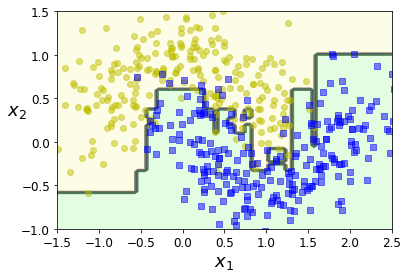

In [9]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

# Weight adjustment in AdaBoost

Let's look at how weight adjustment works when we use AdaBoost. These plots were already shown in the lecture. Here you have the opportunity to check the code out for yourself.

The following bit of code is a visualisation of how the weight adjustment in AdaBoost works. While not relying on the above AdaBoostClassifier class, this implements a support vector machine classifier ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) and boosts the weights of incorrectly classified instances by hand. With different learning rates, the "amount" of boosting can be controlled.

Saving figure boosting_plot


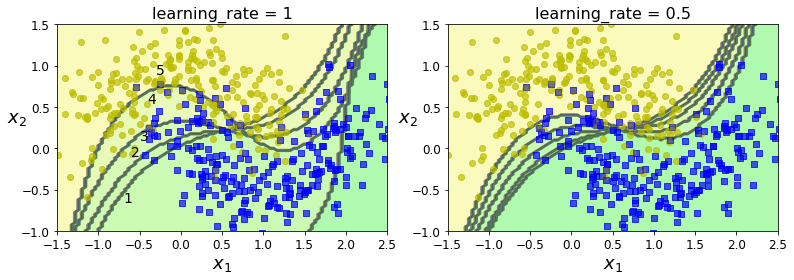

In [10]:
from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    # Start with equal weights for all instances.
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    
    # Now let's go through five iterations where the
    # weights get adjusted based on the previous step.
    for i in range(5):
        # As an example, use SVM classifier with Gaussian kernel.
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        # The most important step: increase the weights of
        # incorrectly predicted instances according to the
        # learning_rate parameter.
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        # And do the plotting.
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

# Gradient Boosting

In the lecture you also encountered the concept of Gradient Boosting which is an alternative to AdaBoost.

Again, gradient boosting sequentially trains multiple predictors which are then combined for a global prediction in the end. 
This means that we again have an ensemble of classifiers.
Gradient boosting fits the new predictor to the _residual errors_ made by the previous predictor, but doesn't touch instance weights. This can be visualised very well with a regression problem (of course, classification can also be performed. Scikit-Learn comes with the two classes [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) and [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) for these tasks. As a first step, the following example implements regression with decision trees by hand.

First, generate our random data.

In [11]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
#Here we generate some quadratic function
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Saving figure gradient_boosting_plot


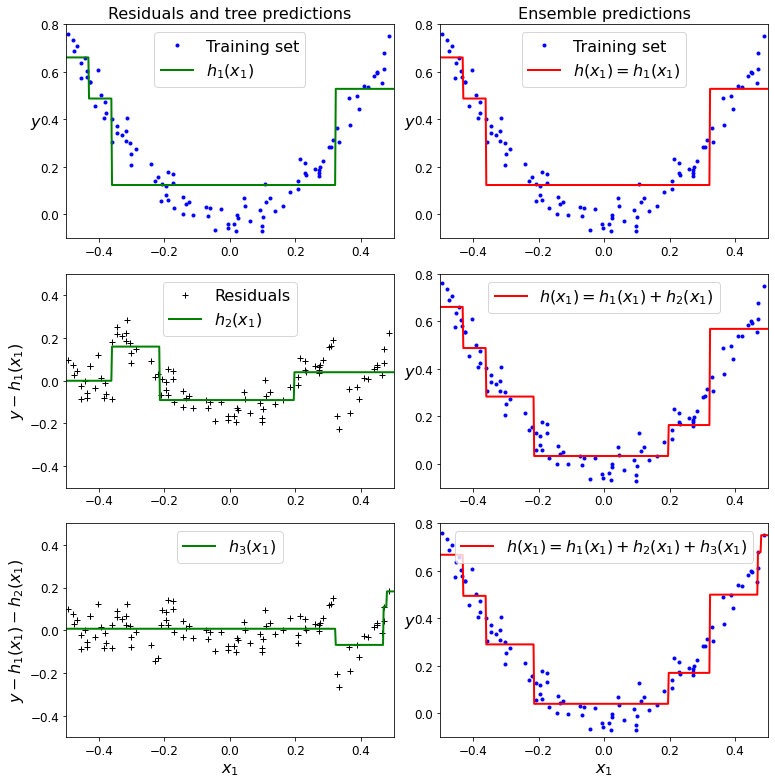

In [12]:
from sklearn.tree import DecisionTreeRegressor

# Start with the first tree and fit it to X, y.
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# Calculate the residual errors the previous tree
# has made and fit a second tree to these.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# Again, calculate the residual errors of the previous
# tree and fit a third tree.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# And the rest is just plotting ...
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

The following piece of code now uses the Scikit-Learn class for regression with gradient boosting. Two examples are given: (1) with a fast learning rate, but only very few predictors, (2) with a slower learning rate, but a high number of predictors. Clearly, the second ensemble overfits the problem. Can you try to tweak the parameters to get a model that generalises better?

Saving figure gbrt_learning_rate_plot


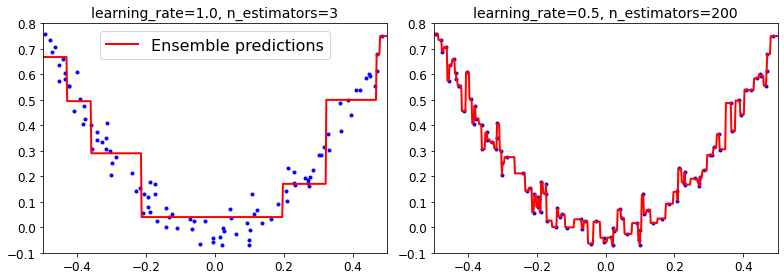

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# First regression instance with only three estimaters,
# but a fast learning rate. The max_depth parameter
# controls the number of 'layers' in the decision
# tree estimators of the ensemble. Increase for stronger
# bias of the individual trees.
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

# Second instance with many estimators and slower
# learning rate.
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.5, random_state=42)
gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

One way to solve this overfitting is to use _early stopping_ to find the optimal number of iterations/predictors for this problem. For that, we first need to split the dataset into training and validation set, because of course we cannot evaluate performance on instances the predictor used in training. The following code implements the already known [model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Then, train another ensemble (with a fixed number of 120 predictors), but this time only on the training set. Errors are calculated based on the validation set and the optimal number of iterations is extracted. The code also creates a plot of the performance on the validation set to point out the optimal iteration.

Saving figure early_stopping_gbrt_plot


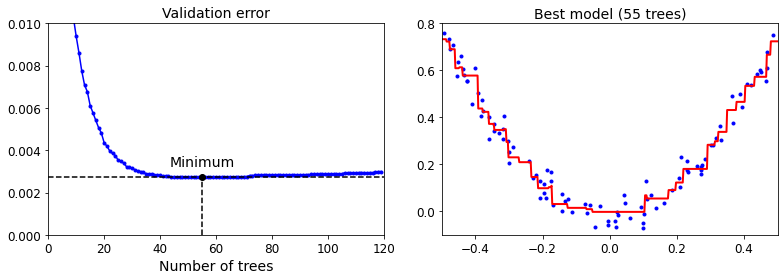

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split dataset into training and validation set.
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# Fit an ensemble. Let's start with 120 estimators, which
# is probably too much (as we saw above).
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# Calculate the errors for each iteration (on the validation set)
# and find the optimal iteration step.
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
min_error = np.min(errors)

# Retrain a new ensemble with those settings.
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

# And do the plotting of validation error as well
# as the optimised ensemble.
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()